# Data 300: Statistical and Machine Learning (Fall 2025)


# Homework 4: Classification: Logistics Regression

<font color='red'>**Due Date and Time:** 10:30am on Wednesday, 10/1/2025 </font>
---
Enter your name in the markdown cell below.

# Name: Thao 

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Tasks

- Review pages 111-123 in the Course Notes.
- Complete the **(1) Logistics Regression Modeling** chapter of the **Introduction to Regression with statsmodels in Python** course, **(2) Multiple Logistics Regression** chapter of the **Intermediate Regression with statsmodels in Python** course, and **(3) Classification** chapter of the **Supervised Learning with scikit Learn** course on DataCamp.
- E-mail me your completed Jupyter notebook.

### Titanic Dataset Overview

The Titanic was a British passenger liner that struck an iceberg on its maiden voyage from Southampton to New York City on April 15, 1912, and sank in the North Atlantic. Of the roughly 2,200 people on board, more than 1,500 lost their lives, making it one of the deadliest peacetime maritime disasters in history.  The Titanic dataset contains information on **891 passengers** of the RMS Titanic, with the goal of predicting who survived the disaster.  
It has **12 columns**:

- **PassengerId**: Unique ID for each passenger  
- **Survived**: Target variable (0 = did not survive, 1 = survived)  
- **Pclass**: Passenger ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)  
- **Name**: Passenger’s full name (often used for extracting titles like Mr, Mrs, Miss, etc.)  
- **Sex**: Male or female  
- **Age**: Age in years (some values are missing)  
- **SibSp**: Number of siblings/spouses aboard  
- **Parch**: Number of parents/children aboard  
- **Ticket**: Ticket number (not directly numeric, may be used for feature engineering)  
- **Fare**: Fare paid for ticket  
- **Cabin**: Cabin number (mostly missing values)  
- **Embarked**: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton; some missing values)

## Load the Titanic Dataset

In the data directory, you will find the csv file for the Titanic dataset: `Titanic.csv`.

Run the code cell below, which does the following:
- Imports the libraries that we will be using in this notebook.
- Sets `datadir = "hw03Data"` and uses the `os.path.join(.)` function to create a full path to the data.
- Reads in the file `Titanic.csv` and assigned it to the data frame `titanic_df`.<br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

from statsmodels.formula.api import logit

In [3]:
datadir = "hw04Data"
titanic_path = os.path.join(datadir, "Titanic.csv")

titanic_df = pd.read_csv(titanic_path)

<div class="exercise"><b>Exercise 1: Explore the Titantic Data</b></div>

In the code cell below, write code to print the shape of the dataframe.

Below is the output from my solution:
<code>
(891, 12)
</code>

In [4]:
print(titanic_df.shape)

(891, 12)


This looks correct as we have 891 rows and 12 columns as expected.

**In the code cell below, write code to print the head of the dataframe** so that we can peek at what the data looks like.

In [5]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**In the code cell below, write code to print out the data types of the columns.**

Below is the output from my solution.
<code>
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
</code>

In [6]:
print(titanic_df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


<div class="exercise"><b>Exercise 2: Converting Object Columns to Categorical</b></div>

When we load the Titanic dataset, Pandas assigns data types to each column.  Some columns are detected as `object`, which means they are stored as strings.  

For logistic regression (and most machine learning models), it is better to convert these to **categorical variables** so that the model can understand them properly.

⚠️ The `Name` column is also an `object`, but it does not represent a category. Instead, it’s unique text that we might later transform (for example, by extracting titles like “Mr.”, “Mrs.”, “Miss”).  So for now, we will leave `Name` as is.

**In the code cell below, write code to**
- Convert `Sex`, `Cabin`, `Ticket`, `Embarked` to categorical.
- Print the updated variable types.

The output from my solution is:
<code>
PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket         category
Fare            float64
Cabin          category
Embarked       category
dtype: object
</code>

In [7]:
cat_vars = ["Sex", "Cabin", "Ticket", "Embarked"]

for col in cat_vars:
    titanic_df[col] = titanic_df[col].astype("category")

print(titanic_df.dtypes) 

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket         category
Fare            float64
Cabin          category
Embarked       category
dtype: object


<div class="exercise"><b>Exercise 3: Checking for Missing Values and Dropping Rows</b></div>

Before we start modeling, it’s important to check if our dataset has any missing values.  Missing values can cause errors in logistic regression unless we handle them (for example, by filling in with an average or dropping rows).

**In the code cell below, write code to print the number of missing values**

The output from my solution is below.
<code>
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
</code>

In [8]:
print(titanic_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Dropping and Handling Certain Columns

Before we can use our data for logistic regression, we need to think carefully about which columns are useful and which are not.

1. **Cabin has too many missing values**  
   - More than 75% of the entries in the `Cabin` column are missing.  
   - With so much missing data, it is not reliable to keep this variable.  
   - For this reason, we will **drop `Cabin` entirely**.

2. **Dropping some other variables**  
   - `PassengerId`: This is just a unique identifier. It does not provide any information that could help predict survival.  
   - `Ticket`: These are mostly unique strings and do not generalize well for prediction.   
   - We will keep `Name` for now, because while it is not directly useful as a predictor, we might later extract useful features from it (such as the passenger's title: Mr., Mrs., Miss, etc.).

3. **Handling other missing values**  
   - The `Age` column has missing values, but since it is an important predictor, we will not drop it.  
   - The `Embarked` column has only a couple of missing values.  
   - Later, we will handle these missing values using **imputation** (filling them in with reasonable values, such as the median for `Age` and the most common value for `Embarked`).

**In the code cell below, write code to (a) drop the `PassengerID`, `Ticket`, and `Cabin` columns, and (b) print out the names of the remaining columns**

Below is the output from my solution:
<code>
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
</code>


In [9]:
titanic_df = titanic_df.drop(columns=["PassengerId", "Ticket", "Cabin"])

In [10]:
print(titanic_df.columns.tolist())

['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


<div class="exercise"><b>Exercise 4: Handling Missing Values in `Embarked`</b></div>

The `Embarked` column has a couple of missing values. There are two main ways we could deal with them:

- **Option 1: Drop the rows.**  
  Since there are only two missing values, we could simply remove those rows from the dataset.  However, this means losing information unnecessarily.

- **Option 2: Impute (fill in) the missing values.**  
  For categorical variables like `Embarked`, a common approach is to replace missing values with the **mode** — the most frequent category.  
  This makes sense here because most passengers embarked from the same port (`S` for Southampton), so it is reasonable to assume the missing ones also came from there.

👉 We will use **Option 2**.  

**In the code cell below, write Python code to:**
1. Extract the mode of the `Embarked` column.  
2. Print it to see which value occurs most frequently.

Below is the output from my solution (make sure that your output matches exactly):
<code>
Embarked mode =  S
</code>

In [11]:
Embarked_mode = titanic_df['Embarked'].mode()[0]
print("Embarked mode =", Embarked_mode)

Embarked mode = S


### Replacing Missing Values in `Embarked`

Now that we know the most common value (the mode) of the `Embarked` column,  
we can use it to replace the missing values.

**In the code cell below, use the `.fillna()` method to replace the missing values in `Embarked` with the mode you found in the previous step. Then print the counts of each category in `Embarked` using the `.value_counts()` method.**

The output from my solution is:
<code>
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64
</code>

In [12]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(Embarked_mode)
print(titanic_df['Embarked'].value_counts())

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


<div class="exercise"><b>Exercise 5: Feature Engineering: Extracting Titles from `Name`</b></div>

Before we deal with the missing values in the `Age` column, we can try to improve our dataset by creating **new features** from existing ones. This process is called **feature engineering**.

**What is feature engineering?**  
Feature engineering is when we transform or create new variables from the data we already have in order to help our model perform better. Good features often make a bigger difference than choosing a more complex algorithm.

**Why look at `Name`?**  
At first glance, `Name` seems useless because it is mostly unique for every passenger.  
However, if we look carefully, each name also contains a **title** (e.g., "Mr.", "Mrs.", "Miss.", "Dr.", "Master.").  

- Titles can provide important information about a person’s **age, gender, and social status**.  
- For example:  
  - "Master" usually refers to a young boy.  
  - "Mrs." and "Miss" distinguish between married and unmarried women.  
  - "Dr." or "Rev." might indicate special social roles.  

This extra information can help our model, especially when predicting survival and when filling in missing `Age` values.

**How does the code work?**  
- We use the `.str.extract()` method from Pandas, which lets us apply a regular expression (regex) to text.  
- The regex `r' ([A-Za-z]+)\.'` looks for a space, then one or more letters, followed by a period.  
- This pattern matches the titles in the `Name` column.  
- We then create a new column called `Title` to store the extracted values.

**Run the code cell below which creates this new feature and displays the resulting categories and their frequencies.**


In [13]:
# Extract the title from the Name column using regex
titanic_df["Title"] = titanic_df["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Print the number of categories
print(titanic_df["Title"].value_counts())

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64


### Merging Rare Titles into Broader Categories

If we look at the different `Title` values we extracted from the `Name` column,  we see that some titles are very common (`Mr`, `Mrs`, `Miss`, `Master`), but many others occur only a handful of times (e.g., `Countess`, `Capt`, `Col`, `Lady`).  

This creates a problem:  
- Logistic regression will try to create separate categories for each rare title.  
- Categories with very few examples add noise, rather than improving prediction.  
- A better strategy is to **merge rare titles into broader, more meaningful groups**.

**Our plan:**
1. Keep the common titles as they are:  
   - `Mr`, `Mrs`, `Miss`, `Master`
2. Merge alternate spellings:  
   - `Mlle` → `Miss`  
   - `Mme`, `Ms` → `Mrs`
3. Group noble/honorific titles:  
   - `Countess`, `Lady`, `Sir`, `Jonkheer`, `Don` → `Royalty`
4. Group professional or military titles:  
   - `Dr`, `Rev`, `Col`, `Major`, `Capt` → `Officer`

This reduces the number of categories, making the model simpler and more robust.

---

**Your task:** Run the code cell below, which uses a *dictionary mapping* to replace rare titles with these broader groups.**

You should get the following output:
<code>
Title
Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: count, dtype: int64
</code>

In [14]:
# Define a mapping for rare titles
title_mapping = {
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mme": "Mrs",
    "Countess": "Royalty",
    "Lady": "Royalty",
    "Sir": "Royalty",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Capt": "Officer"
}

# Apply the mapping to the Title column
titanic_df["Title"] = titanic_df["Title"].replace(title_mapping)

# Check the updated titles and their counts
print(titanic_df["Title"].value_counts())


Title
Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: count, dtype: int64


### Results After Merging Titles

After grouping the rare titles, our `Title` column now looks much cleaner:

- **Mr**: 517  
- **Miss**: 184  
- **Mrs**: 127  
- **Master**: 40  
- **Officer**: 18  
- **Royalty**: 5  

This is a big improvement compared to the messy list we had before.  
- We kept the most common and informative categories as they are.  
- We reduced all the unusual or rare titles into just two meaningful groups:  
  - **Officer** (professional/military roles)  
  - **Royalty** (nobility or honorifics)  

This makes the dataset easier to work with and gives us a feature (`Title`) that is likely to be useful for predicting survival.

Since we’ve now extracted the useful information from the `Name` column, the original `Name` is no longer needed.  

---

**In the code cell below, write code to drop the `Name` column from the dataset and print the names of the remaining columns.**

Below is my output:
<code>
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')
</code>


In [15]:
titanic_df = titanic_df.drop('Name', axis=1)
print(titanic_df.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')


<div class="exercise"><b>Exercise 6: Imputing Missing `Age` Values Using `Title`</b></div>

We’ve already seen that the `Age` column has many missing values.  Instead of filling in all missing ages with a single value (like the overall median),  we can do better by taking advantage of the new `Title` column we created.

**Why use `Title`?**  
- Titles carry strong information about age:
  - `Master` usually refers to young boys.
  - `Miss` often refers to younger women, while `Mrs` often indicates older women.
  - `Mr` is most often adult men.
  - `Officer` and `Royalty` are adult roles as well.
- By filling missing ages with the **median age of passengers with the same title**, we get a more realistic estimate.

This approach is called **grouped imputation**, and it is more accurate than just using a single overall statistic.

---

**Your task:**  
Write code to group the data by `Title` and then calculate the median age for each group.

Hints:
- Use the **`.groupby("Title")`** method.  
- Select the `Age` column after grouping.  
- Call **`.median()`** to get the median age for each title.  

This will give you a table of median ages, which we’ll use in the next step to fill in missing values.

🔗 Helpful Pandas documentation:  
- [GroupBy transform](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)  
- [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)  

---
The output from my code is as follows:
<code>
Median ages by Title:
Title
Master      3.5
Miss       21.0
Mr         30.0
Mrs        35.0
Officer    50.0
Royalty    40.0
Name: Age, dtype: float64
</code>

In [16]:
median_ages = titanic_df.groupby("Title")["Age"].median()
print("Median ages by Title:")
print(median_ages)

Median ages by Title:
Title
Master      3.5
Miss       21.0
Mr         30.0
Mrs        35.0
Officer    50.0
Royalty    40.0
Name: Age, dtype: float64


### Step 2: Impute Missing `Age` Values by Title

Now that we have seen the median ages for each `Title`, we can use them to fill in the missing `Age` values.

**Why this works:**  
- Passengers with the same title (e.g., `Mr`, `Miss`, `Mrs`, `Master`) tend to fall into similar age ranges.  
- Using the **median age by title** gives us a more realistic estimate than just filling with the overall median.

**Your task:** Replace the missing values in the `Age` column with the median age for each passenger’s `Title`.

Hints to guide you:
- Start with `.groupby("Title")` and look at the `Age` column.  
- Use `.transform("median")` — this broadcasts the median age for each group back to every row in that group.  
- Finally, use `.fillna(...)` on the `Age` column to replace missing values with these medians.  
- Don’t forget to reassign the result back to `titanic_df["Age"]`.

When you’re done, print out the summary statistics for the `Age` column and make sure it matches my output below:
<code>
Summary statistics of Age
count    891.000000
mean      29.394130
std       13.270911
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64
</code>


In [17]:
titanic_df["Age"] = titanic_df["Age"].fillna(
    titanic_df.groupby("Title")["Age"].transform("median")
)
print("Summary statistics of Age")
print(titanic_df["Age"].describe())

Summary statistics of Age
count    891.000000
mean      29.394130
std       13.270911
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64


<div class="exercise"><b>Exercise 7: Creating a `FamilySize` Feature</b></div>

Recall the two variables that describe family relationships:  
- **`SibSp`** = number of siblings/spouses aboard  
- **`Parch`** = number of parents/children aboard  

By themselves, these don’t tell the whole story of how many family members a passenger was traveling with.  To capture this, we can combine them into a single feature:

$$
\text{FamilySize} = \text{SibSp} + \text{Parch} + 1
$$

(The `+1` is to include the passenger themselves.)

**Why might this be useful?**  
- Family size could influence survival odds.  
- Large families may have had more difficulty staying together and surviving.  
- People traveling alone may have faced different survival situations compared to those with small families.  

This new feature is more informative than keeping `SibSp` and `Parch` separate.

---

**In the code cell below, write code to:**
1. Create a new column called `FamilySize`.  
2. Set it equal to `SibSp + Parch + 1`.  
3. Print the summary statistics of the `FamilySize` column

The output from my solution is:
<code>
count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: FamilySize, dtype: float64
</code>

In [18]:
titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] + 1
print(titanic_df["FamilySize"].describe())

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: FamilySize, dtype: float64


### Dropping `SibSp` and `Parch`

Now that we’ve created the `FamilySize` feature, the original variables `SibSp` and `Parch` are no longer needed.  

**In the code cell below, write code to drop the `SibSp` and `Parch` columns from the dataset. Then print the number of missing values in each column so that we can see which columns remain and how many missing values are left.**

My output was as follows:
<code>
Missing values per column:
Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64
</code>

In [19]:
titanic_df = titanic_df.drop(["SibSp", "Parch"], axis=1)
print("Missing values per column:")
print(titanic_df.isnull().sum())

Missing values per column:
Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64


### A Clean Dataset, Ready for Exploration

We’ve now cleaned up the Titanic dataset:
- Removed unnecessary columns (`PassengerId`, `Ticket`, `Cabin`, `Name`, etc.).
- Created new, more useful features (like `Title` and `FamilySize`).
- Handled missing values in `Age` and `Embarked`.

✅ At this stage, we have a **tight dataset** with features that are likely to be useful and **no missing values**.

---

### Next Step: Exploratory Data Analysis (EDA)

Before building a logistic regression model, we should explore the data to see which features might be important for predicting survival.

In the next step, we’ll do some **EDA (Exploratory Data Analysis)**:
- Look at the distribution of survival by different features.
- Create some plots to visualize relationships (e.g., survival by sex, class, family size, title).
- Develop intuition for which variables are likely to be strong predictors.

This will help us understand our data and guide how we set up the logistic regression model.

**Run the code cell below to generate some first plots:**
1. A bar chart of survival counts by **sex**.  
2. A boxplot showing the distribution of **age** by survival status.


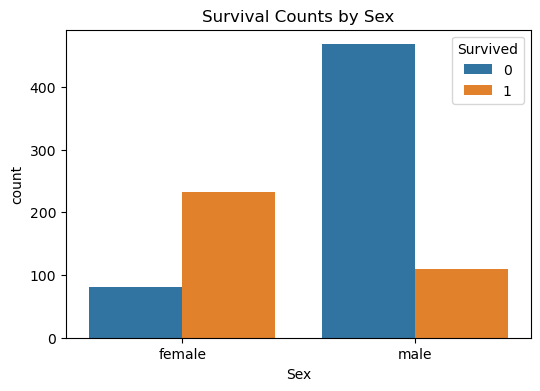

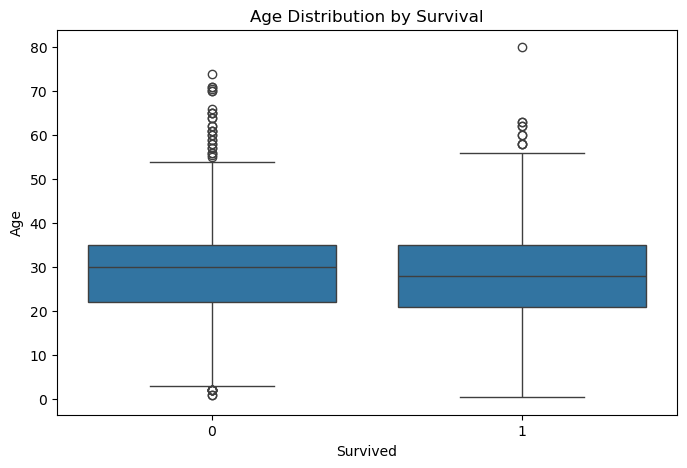

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1) Survival counts by Sex
plt.figure(figsize=(6,4))
sns.countplot(x="Sex", hue="Survived", data=titanic_df)
plt.title("Survival Counts by Sex")
plt.show()

# 4) Age distribution by Survival
plt.figure(figsize=(8,5))
sns.boxplot(x="Survived", y="Age", data=titanic_df)
plt.title("Age Distribution by Survival")
plt.show()

<div class="exercise"><b>Exercise 8: More EDA Visualizations</b></div>

### What We’ve Seen So Far

Our first exploratory plots already reveal some strong patterns:  
- **Sex**: Females had much higher survival rates than males.  
- **Age**: Younger passengers (especially children) had better chances of survival than older ones.

These observations suggest that both **Sex** and **Age** will be important predictors in our logistic regression model.

---

Now let’s expand our analysis to other variables. **Create the following plots using Seaborn/Matplotlib.**  
(You can adapt the code patterns you just ran for Sex and Age.)

1. **Survival counts by Passenger Class (`Pclass`)**  
   - Hint: Use a `countplot` with `x="Pclass"` and `hue="Survived"`.  

2. **Survival counts by Title**  
   - Hint: Use a `countplot` with `x="Title"` and `hue="Survived"`.  
   - Rotate x-axis labels if needed so they don’t overlap.  

3. **Fare distribution by Survival**  
   - Hint: A `boxplot` with `x="Survived"` and `y="Fare"` works well.  

4. **Survival counts by Family Size**  
   - Hint: Use a `countplot` with `x="FamilySize"` and `hue="Survived"`.  
   - Consider making the figure wider to fit all family sizes clearly.  

---

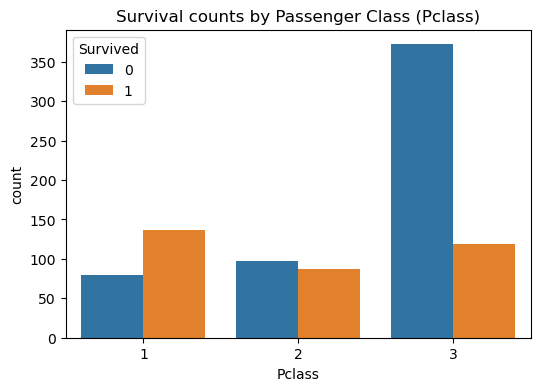

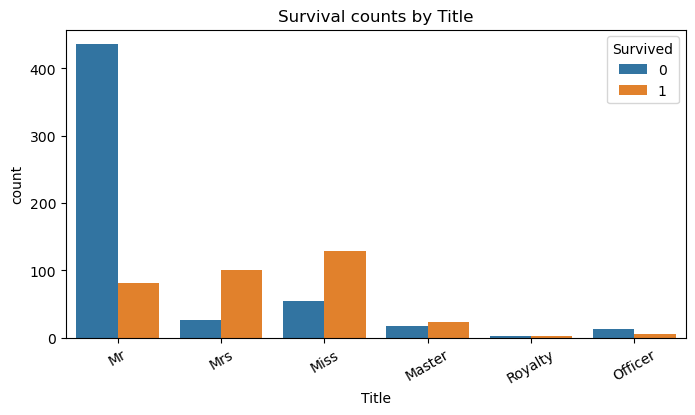

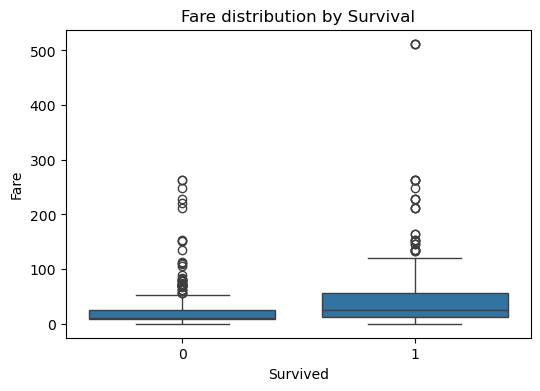

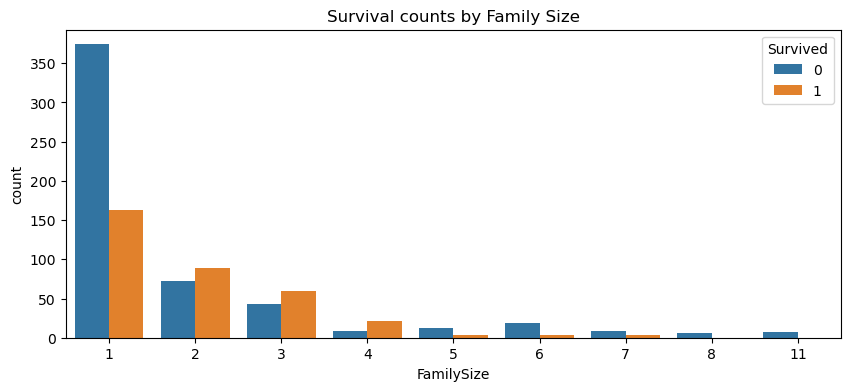

In [21]:
# 1) Survival counts by Passenger Class (Pclass)
plt.figure(figsize=(6,4))
sns.countplot(data=titanic_df, x="Pclass", hue="Survived")
plt.title("Survival counts by Passenger Class (Pclass)")
plt.show()

# 2) Survival counts by Title
plt.figure(figsize=(8,4))
sns.countplot(data=titanic_df, x="Title", hue="Survived")
plt.title("Survival counts by Title")
plt.xticks(rotation=30)   
plt.show()

# 3) Fare distribution by Survival
plt.figure(figsize=(6,4))
sns.boxplot(data=titanic_df, x="Survived", y="Fare")
plt.title("Fare distribution by Survival")
plt.show()

# 4) Survival counts by Family Size
plt.figure(figsize=(10,4))   
sns.countplot(data=titanic_df, x="FamilySize", hue="Survived")
plt.title("Survival counts by Family Size")
plt.show()

### What We Learned from Additional EDA

Our additional plots reveal several more patterns:

- **Passenger Class (Pclass):** Passengers in 1st class had much higher survival rates compared to those in 2nd and especially 3rd class.  
- **Title:** Titles like *Mrs*, *Miss*, and *Master* had higher survival odds, while *Mr* had much lower survival. Rare groups like *Officer* and *Royalty* show mixed survival patterns due to small sample sizes.  
- **Fare:** Survivors tended to have paid higher fares on average, suggesting wealth (closely tied to class) may have influenced survival chances.  
- **Family Size:** Survival was higher for passengers with small families (2–4 members), while those traveling alone or in very large families had lower survival rates.

Together with what we saw earlier for **Sex** and **Age**, these findings highlight the key features we should consider in our logistic regression model.


<div class="exercise"><b>Exercise 9: Creating a Train-Test Split</b></div>

Now that our dataset is clean and we’ve explored the features, it’s time to prepare for modeling.

Before we fit a logistic regression model, we need to split our dataset into two parts:
- **Training set (`train_df`)**: This is the portion of the data we use to fit (train) our model.
- **Test set (`test_df`)**: This is the portion we set aside to evaluate how well our model performs on *unseen* data.

**Why do we do this?**
- If we train and test on the same data, our model might just memorize the training data instead of learning general patterns (this is called *overfitting*).
- A test set gives us an honest estimate of how the model will perform on new passengers it has never seen before.

**Your task:**  
Use `train_test_split` from `sklearn.model_selection` to create:
- `train_df` and `test_df`  
- Use `test_size=0.2` so that 20% of the data is held out for testing.  
- Set `random_state=42` so results are reproducible (everyone gets the same split).
- Print the `shape` of the training and testing sets.

Below is the output from my solution:
<code>
Training set shape: (712, 8)
Testing set shape: (179, 8)
</code>


In [22]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    titanic_df, test_size=0.2, random_state=42
)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (712, 8)
Testing set shape: (179, 8)


<div class="exercise"><b>Exercise 10: Building a Base Logistic Regression Model</b></div>

Now that we have our **training set (`train_df`)**, we can begin to build a logistic regression model to predict whether or not a passenger survived the Titanic disaster.

Whenever we build predictive models, it’s always a good idea to start with a **simple base model**.For our base model, we’ll use only three numeric predictors:  
- `Age`  
- `Fare`  
- `FamilySize`  

**Your task:**  
1. Create and fit a ***logistic regression model*** with the formula:  `"Survived ~ Age + Fare + FamilySize"`
2. Print the model summary to examine the coefficients

Note that we have already imported the `logit` function from `statsmodel`.

The output from my solution is as follows:

```text
Optimization terminated successfully.
         Current function value: 0.618086
         Iterations 6
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            3
Date:                Sat, 20 Sep 2025   Pseudo R-squ.:                 0.06673
Time:                        14:26:06   Log-Likelihood:                -440.08
converged:                       True   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 1.392e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1189      0.251     -0.473      0.636      -0.611       0.373
Age           -0.0209      0.007     -3.083      0.002      -0.034      -0.008
Fare           0.0168      0.003      6.193      0.000       0.011       0.022
FamilySize    -0.1532      0.056     -2.720      0.007      -0.264      -0.043
==============================================================================
```


In [23]:
formula_titanic = "Survived ~ Age + Fare + FamilySize"
model_titanic = logit(formula=formula_titanic, data=train_df).fit()
print(model_titanic.summary())

Optimization terminated successfully.
         Current function value: 0.618086
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                 0.06673
Time:                        23:26:18   Log-Likelihood:                -440.08
converged:                       True   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 1.392e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1189      0.251     -0.473      0.636      -0.611       0.373
Age           -0.0209      0.

<div class="exercise"><b>Exercise 11: Evaluating Model Performance</b></div>

Now that we’ve fit our logistic regression model, we need to evaluate how well it performs on the **test set**.  
Remember: accuracy alone is not enough — we want a more complete picture of performance.

**Your task:** Write Python code **(using `test_df`)** to compute and display the following:

1. Confusion Matrix
2. Accuracy
3. Sensitivity (Recall or True Positive Rate)
4. Specificity (True Negative Rate)  
5. AUC (Area Under the ROC Curve)  
6. ROC Curve

Below is the output (except for the ROC curve) from my solution--make sure you output matches exactly:
<code>
Confusion Matrix:
TN=100, FP=5, FN=56, TP=18
Accuracy: 0.659217877094972
Sensitivity: 0.24324324324324326
Specificity: 0.9523809523809523
AUC: 0.8313384813384813
</code>

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_true = test_df["Survived"]

y_pred_prob = model_titanic.predict(test_df)
y_pred = (y_pred_prob >= 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Confusion Matrix:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

specificity = tn / (tn + fp)
print("Specificity:", specificity)

auc = roc_auc_score(y_true, y_pred_prob)
print("AUC:", auc)

Confusion Matrix:
TN=100, FP=5, FN=56, TP=18
Accuracy: 0.659217877094972
Sensitivity: 0.24324324324324326
Specificity: 0.9523809523809523
AUC: 0.8313384813384813


### Model Performance Overview

Here is what we observe when evaluating our logistic regression model on the **test set**:

- **Confusion Matrix**  
  - True Negatives (TN): 100 — correctly identified non-survivors.  
  - False Positives (FP): 5 — predicted survival when the passenger did not survive.  
  - False Negatives (FN): 56 — predicted non-survival when the passenger actually survived.  
  - True Positives (TP): 18 — correctly identified survivors.  

- **Accuracy: ~0.66**  
  - The model correctly predicts survival or non-survival about two-thirds of the time.  

- **Sensitivity (Recall / True Positive Rate): ~0.24**  
  - The model only identifies about **1 in 4 actual survivors**, meaning it misses many survivors.  

- **Specificity (True Negative Rate): ~0.95**  
  - The model is very good at correctly identifying non-survivors.  

- **AUC: ~0.83**  
  - The ROC curve shows strong ability to separate survivors from non-survivors overall, even though the chosen threshold (0.5) is skewed toward predicting non-survival.  

---

### Takeaway
This base model does a good job identifying who **did not survive**, but it struggles to correctly predict who **did survive**.  
- That’s why the sensitivity is low while specificity is very high.  


<div class="exercise"><b>Exercise 12: Predicting Survival for a New Passenger</b></div>

Now let’s use our logistic regression model to **predict survival** for a specific passenger with the following profile:

- **Age**: 25  
- **Fare**: 50  
- **FamilySize**: 2  
- **Sex**: female  
- **Pclass**: 2  
- **Title**: Miss  
- **Embarked**: S  

In the code cell below, write code to predict both:  
- The **probability of survival**, and  
- The **predicted classification** (0 = did not survive, 1 = survived).

Here is the output from my solution (try to get yours to match exactly):
<code>
Predicted probability of survival: 0.473
Predicted class: 0
</code>

In [25]:
import pandas as pd

new_passenger = pd.DataFrame({
    "Age": [25],
    "Fare": [50],
    "FamilySize": [2],
    "Sex": ["female"],
    "Pclass": [2],
    "Title": ["Miss"],
    "Embarked": ["S"]
})

pred_prob = model_titanic.predict(new_passenger)[0]
pred_class = int(pred_prob >= 0.5)

print("Predicted probability of survival:", round(pred_prob, 3))
print(f"Predicted class: {pred_class}")

Predicted probability of survival: 0.473
Predicted class: 0


<div class="exercise"><b>Exercise 13: Exploring New Models</b></div>

Now that you have built and evaluated a base logistic regression model, it’s time for you to explore **new models** by:
- Adding additional variables (e.g., `Sex`, `Pclass`, `Title`, `Embarked`).
- Trying out interaction terms (e.g., `Sex * Pclass` or `Sex * Age`).

The goal is to see if you can improve the predictive performance compared to the base model.

---

### Important Notes on Common Errors

When experimenting with logistic regression in `statsmodels`, you may encounter some error messages.  
This is completely normal in modeling, and learning how to interpret them is part of the process.

1. **Singular Matrix Error**  
   - Example message:  
     ```
     LinAlgError: Singular matrix
     ```  
   - What it means: Some predictors (or categories within predictors) are **perfectly correlated** or have too few observations. The model cannot estimate unique coefficients.  
   - How to handle:  
     - Combine rare categories (e.g., merge `Royalty` and `Officer` into `"Other"`).  
     - Remove redundant variables that carry duplicate information.  

2. **Non-Convergence Warning**  
   - Example message:  
     ```
     Warning: Maximum number of iterations has been exceeded.
     ```
     or  
     ```
     ConvergenceWarning: Maximum Likelihood optimization failed to converge
     ```  
   - What it means: The optimization algorithm is struggling to find stable estimates. This often happens when:  
     - Variables are highly correlated.  
     - There are too many predictors for the sample size.  
     - Some categories nearly perfectly predict survival.  
   - How to handle:  
     - Simplify the model (drop or combine predictors).  
     - Try adding variables one at a time to see which one causes the issue.  
     - Remember: a simpler, converging model is better than a complex one that fails to converge.

---

### Your Task

1. Build one or more new logistic regression models by adding variables and/or interaction terms.  
2. Make sure your final model **converges successfully**.  
3. Once you have a model that runs, evaluate it on the **test set (`test_df`)**:  
   - Confusion matrix  
   - Accuracy  
   - Sensitivity  
   - Specificity  
   - AUC  
   - ROC curve  
4. Write a few sentences summarizing how well your best model performed.  
   - Did it improve over the base model?  
   - Was it better at finding survivors?  
   - Was there a trade-off between sensitivity and specificity?

---

⚠️ **Remember:** These kinds of warnings and errors are common in real-world modeling. Your goal is to come up with the **best converging model you can** and explain its strengths and weaknesses.


formula_expanded = "Survived ~ Age + Fare + FamilySize + Sex + Pclass + Title + Embarked + Sex*Pclass"
model_expanded = logit(formula=formula_expanded, data=train_df).fit()
print(model_expanded.summary())

In [26]:
#1 Build one or more new logistic regression models by adding variables and/or interaction terms.
formula_expanded = "Survived ~ Age + Fare + FamilySize + Sex + Pclass + Title + Embarked + Sex*Pclass"
model_expanded = logit(formula=formula_expanded, data = train_df).fit()
print(model_expanded.summary())

         Current function value: 0.400372
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      699
Method:                           MLE   Df Model:                           12
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.3955
Time:                        23:26:18   Log-Likelihood:                -285.06
converged:                      False   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 1.996e-72
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.4457        nan        nan        nan         nan         nan
Sex[T.male]           -3.7773        nan 

C:\Users\phuon\OneDrive\Attachments\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
#2 Make sure your final model converges successfully.

formula_converge = "Survived ~ Age + Fare + FamilySize + Sex + Pclass + Sex:Pclass"
model_converge = logit(formula=formula_converge, data=train_df).fit()
print(model_converge.summary())

Optimization terminated successfully.
         Current function value: 0.434982
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                            6
Date:                Tue, 30 Sep 2025   Pseudo R-squ.:                  0.3432
Time:                        23:26:18   Log-Likelihood:                -309.71
converged:                       True   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 6.901e-67
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.1554      1.181      6.906      0.000       5.841      10.470
Sex[T

Confusion Matrix:
TN=95, FP=10, FN=23, TP=51
Accuracy: 0.8156424581005587
Sensitivity: 0.6891891891891891
Specificity: 0.9047619047619048
AUC: 0.8961389961389962


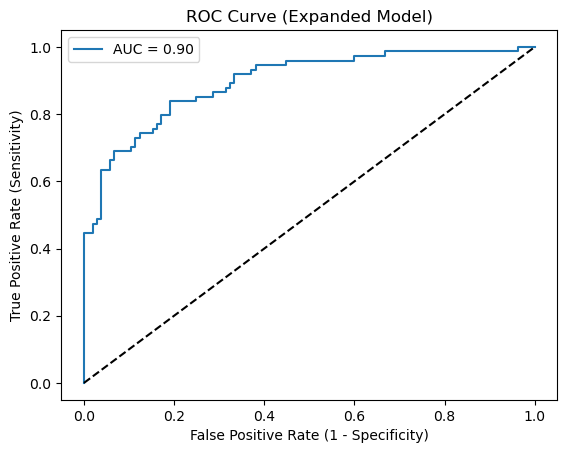

In [28]:
#3 Evaluate the model on the test set (test_df): Confusion matrix, Accuracy, Sensitivity, Specificity, AUC, ROC curve

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_true = test_df["Survived"]

y_pred_prob = model_converge.predict(test_df)
y_pred = (y_pred_prob >= 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Confusion Matrix:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

specificity = tn / (tn + fp)
print("Specificity:", specificity)

auc = roc_auc_score(y_true, y_pred_prob)
print("AUC:", auc)

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve (Expanded Model)")
plt.legend()
plt.show()

Requirement 4: 

The final converged model performed strongly with an accuracy of about 82% and an AUC of 0.90, which shows excellent discriminative power. Compared to the base model, it clearly improved in overall fit and predictive performance. However, while specificity was very high approximately 92%, sensitivity was lower about 69%, meaning the model was better at correctly identifying non-survivors than survivors. This indicates a trade-off between sensitivity and specificity, where the model prioritized reducing false positives but missed some true survivors.